In [259]:
from importing_sb import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline

data_dir = '/Users/jm533/Documents/GitHub/football_analytics/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [2]:
years = list(range(2015,2003,-1))
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

In [3]:
event_data = {}
for year in years:
    event_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(open_data(data_dir + 'events/{}.json'.format(str(match))))

In [4]:
shots = {}
for year in years:
    shots[str(year)] = [get_shots(match) for match in event_data[str(year)]]

In [5]:
shots_all_list = []
for year in years:
    shots_all_list.append(pd.concat(shots[str(year)]))

In [107]:
shots_all = pd.concat(shots_all_list)
shots_all.reset_index(inplace=True)
# There are so few times when a shot follows a dribble! Will remove from data set
shots_all.drop(['follows_dribble'],axis=1,inplace=True)

In [108]:
shots_all

,level_0,index,period,minute,second,type,pos_team,play_pattern,team,player,...,end_z,first_time,freeze_frame,open_goal,sb_xg,deflection,technique,body_part,shot_type,outcome
0,0,741,1,14,17,Shot,Athletic Bilbao,From Free Kick,Athletic Bilbao,Sabin Merino Zuloaga,...,0.3,True,"[{'location': [83.7, 36.7], 'player': {'id': 6...",False,0.017096,False,Normal,Right Foot,Open Play,Saved
1,1,988,1,20,40,Shot,Barcelona,From Throw In,Barcelona,Andrés Iniesta Luján,...,NaN,True,"[{'location': [106.9, 40.1], 'player': {'id': ...",False,0.074108,False,Normal,Left Foot,Open Play,Blocked
2,2,1030,1,23,34,Shot,Athletic Bilbao,From Free Kick,Athletic Bilbao,Aritz Aduriz Zubeldia,...,0.7,False,"[{'location': [92.2, 26.8], 'player': {'id': 6...",False,0.047723,False,Normal,Head,Open Play,Off T
3,3,1293,1,30,15,Shot,Barcelona,Other,Barcelona,Lionel Andrés Messi Cuccittini,...,0.2,False,None,False,0.760000,False,Normal,Left Foot,Penalty,Saved
4,4,1377,1,32,8,Shot,Barcelona,Regular Play,Barcelona,Andrés Iniesta Luján,...,4.2,False,"[{'location': [73.9, 60.7], 'player': {'id': 6...",False,0.029790,False,Normal,Right Foot,Open Play,Off T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,21,2484,2,65,53,Shot,Barcelona,Regular Play,Barcelona,"Samuel Eto""o Fils",...,1.3,True,"[{'location': [105.6, 38.2], 'player': {'id': ...",False,0.031566,False,Normal,Right Foot,Open Play,Goal
8508,22,3088,2,80,55,Shot,Barcelona,From Free Kick,Barcelona,Giovanni van Bronckhorst,...,1.9,False,"[{'location': [119.8, 43.2], 'player': {'id': ...",False,0.007983,False,Normal,Left Foot,Free Kick,Saved
8509,23,3316,2,85,7,Shot,Barcelona,Regular Play,Barcelona,Ludovic Giuly,...,3.2,False,"[{'location': [119.0, 42.2], 'player': {'id': ...",False,0.054056,False,Normal,Right Foot,Open Play,Off T
8510,24,3428,2,90,14,Shot,Barcelona,From Counter,Barcelona,Lionel Andrés Messi Cuccittini,...,0.6,True,"[{'location': [113.0, 34.1], 'player': {'id': ...",False,0.148396,False,Lob,Left Foot,Open Play,Goal


In [109]:
shots_all.columns

Index(['level_0', 'index', 'period', 'minute', 'second', 'type', 'pos_team',
       'play_pattern', 'team', 'player', 'x', 'y', 'duration',
       'under_pressure', 'end_x', 'end_y', 'end_z', 'first_time',
       'freeze_frame', 'open_goal', 'sb_xg', 'deflection', 'technique',
       'body_part', 'shot_type', 'outcome'],
      dtype='object')

In [110]:
print(shots_all.play_pattern.value_counts())

Regular Play      2878
From Free Kick    2165
From Throw In     1329
From Corner       1155
From Counter       344
From Goal Kick     301
Other              130
From Kick Off      107
From Keeper        103
Name: play_pattern, dtype: int64


In [168]:
shots_all_simple = shots_all[(shots_all['open_goal'] == False)&(shots_all['deflection'] == False)
                             &(shots_all['technique'] == 'Normal')
                             &(shots_all['body_part'] != 'Head')&(shots_all['body_part'] != 'Other')
                            &(shots_all['shot_type'] == 'Open Play')&(shots_all['outcome'] != 'Blocked')]

shots_all_ref = shots_all[(shots_all['open_goal'] == False)&(shots_all['deflection'] == False)
                             &(shots_all['technique'] == 'Normal')
                             &(shots_all['body_part'] != 'Other')
                            &(shots_all['shot_type'] != 'Corner')&(shots_all['outcome'] != 'Blocked')
                             &(shots_all['play_pattern'] != 'From Goal Kick')
                              &(shots_all['play_pattern'] != 'From Kick Off')
                             &(shots_all['play_pattern'] != 'From Keeper')]
#&(shots_all['play_pattern'] != 'Other')&(shots_all['play_pattern'] != 'From Goal Kick')
                             #&(shots_all['play_pattern'] != 'From Kick Off')&(shots_all['play_pattern'] != 'From Keeper')

In [156]:
shots_all_ref.play_pattern.value_counts()

Regular Play      1792
From Free Kick    1309
From Throw In      791
From Corner        630
From Counter       234
From Goal Kick     177
Other              124
From Kick Off       63
From Keeper         63
Name: play_pattern, dtype: int64

In [121]:
x2 = 120
y2 = 40
x1 = shots_all_simple['x'].values
y1 = shots_all_simple['y'].values

d = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
ang = np.arctan(np.absolute((y2-y1))/np.absolute((x2-x1)))*(180/np.pi)

In [122]:
shots_model = pd.DataFrame()
shots_model['isGoal'] = (shots_all_simple['outcome'] == 'Goal').astype('int').reset_index(drop=True)
shots_model['dist'] = d
shots_model['angle'] = ang

In [123]:
X = shots_model[['dist','angle']]
y = shots_model['isGoal'].values
model = sm.Logit(y,X)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.384703
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.136      
Dependent Variable: y                AIC:              2856.9550  
Date:               2020-02-24 20:52 BIC:              2869.3915  
No. Observations:   3708             Log-Likelihood:   -1426.5    
Df Model:           1                LL-Null:          -1651.2    
Df Residuals:       3706             LLR p-value:      9.2701e-100
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
dist      -0.0908     0.0040   -22.5170   0.0000   -0.0988   -0.0829
angle     -0.0025     0.0019    -1.3231   0.1

In [194]:
x2 = 120
y2 = 40
x1 = shots_all_ref['x'].values
y1 = shots_all_ref['y'].values

d = np.sqrt((x2-x1) ** 2 + (y2-y1) ** 2)
ang = np.arctan(np.absolute((y2-y1))/np.absolute((x2-x1)))*(180/np.pi)

In [203]:
shots_model = pd.DataFrame()
shots_model['isGoal'] = (shots_all_ref['outcome'] == 'Goal').astype('int').reset_index(drop=True)
shots_model['dist'] = d
shots_model['angle'] = ang
shots_model['isHead'] = (shots_all_ref['body_part'] == 'Head').astype('int').reset_index(drop=True)
shots_model['isFirstTime'] = shots_all_ref['first_time'].astype('int').reset_index(drop=True)
shots_model['isUnderPress'] = shots_all_ref['under_pressure'].astype('int').reset_index(drop=True)
shots_model['isFK'] = (shots_all_ref['shot_type'] == 'Free Kick').astype('int').reset_index(drop=True)
shots_model['isPen'] = (shots_all_ref['shot_type'] == 'Penalty').astype('int').reset_index(drop=True)
#shots_model['isFromReg'] = (shots_all_ref['play_pattern'] == 'Regular Play').astype('int').reset_index(drop=True)
#shots_model['isFromFK'] = (shots_all_ref['play_pattern'] == 'From Free Kick').astype('int').reset_index(drop=True)
#shots_model['isFromThrow'] = (shots_all_ref['play_pattern'] == 'From Throw In').astype('int').reset_index(drop=True)
shots_model['isFromCorner'] = (shots_all_ref['play_pattern'] == 'From Corner').astype('int').reset_index(drop=True)
shots_model['isFromCounter'] = (shots_all_ref['play_pattern'] == 'From Counter').astype('int').reset_index(drop=True)

In [204]:
X = shots_model[['dist','angle','isHead','isFirstTime','isUnderPress','isFK','isPen','isFromCorner','isFromCounter']]
y = shots_model['isGoal'].values
model = sm.Logit(y,X)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.372383
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.166      
Dependent Variable: y                AIC:              3652.4572  
Date:               2020-02-24 21:14 BIC:              3710.8933  
No. Observations:   4880             Log-Likelihood:   -1817.2    
Df Model:           8                LL-Null:          -2178.8    
Df Residuals:       4871             LLR p-value:      7.6171e-151
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
dist              -0.0936   0.0043 -21.8698 0.0000 -0.1020 -0.0852
angle             -0.0055   0.0019  -2.9021 0.0037 -0

In [205]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X['intercept'] = 1
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,dist,1.691481
1,angle,1.189476
2,isHead,1.954213
3,isFirstTime,1.213349
4,isUnderPress,1.154796
5,isFK,1.189280
6,isPen,1.178720
7,isFromCorner,1.234182
8,isFromCounter,1.034382
9,intercept,19.179705


In [206]:
skl_lm.LogisticRegression?

In [207]:
skl_lm.LinearRegression?
result = reg.fit(adv.TV.values.reshape(-1,1), adv.Sales)

In [235]:
reg = skl_lm.LogisticRegression()
#test = reg.fit(X[['dist','angle']], y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

/Users/jm533/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.855191256830601

In [244]:
prediction = reg.predict(X_test)
conf_matrix = confusion_matrix(y_test, prediction)
print(conf_matrix)

[[1188   28]
 [ 184   64]]


In [249]:
pred = reg.predict_proba(X_test)[:,1]

In [252]:
fpr, tpr, _ = roc_curve(y_test, pred)

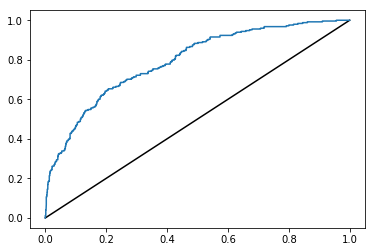

In [258]:
plt.plot([0,1],[0,1],'k')
plt.plot(fpr,tpr)
plt.show()

In [264]:
print(len(y_test))
print(len(pred))

1464
1464


In [265]:
roc_auc_score(y_test,pred)

0.7931411820882852